In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import os
from pathlib import Path

In [2]:
#hyperparameter
batch_size = 32
epochs = 40
lr = 0.001
try_cuda = True
seed = 1000
colab = True
#storing train/test/valid result as 2d array
#1:lenet5 | 2:ResNet18 3:ResNet50 4:ResNet101 | 5:DenseNet121 6:DenseNet161
train_accuracy = np.zeros((6,epochs))
test_accuracy = np.zeros((6,epochs))
valid_accuracy = np.zeros((6,epochs))
# Architecture
num_classes = 2
best_accuracy  = 0

#otherum
logging_interval = 10 # how many batches to wait before logging
logging_dir = None
grayscale = False

In [3]:
#logging settings
datetime_str = datetime.now().strftime('%b%d_%H-%M-%S')

# if logging_dir is None:
#     runs_dir = Path("./") / Path(f"runs/")
#     runs_dir.mkdir(exist_ok = True)

#     logging_dir = runs_dir / Path(f"{datetime_str}")

#     logging_dir.mkdir(exist_ok = True)
#     logging_dir = str(logging_dir.absolute())

#writer = SummaryWriter(log_dir=logging_dir)

#deciding whether to send to the cpu or not if available
if torch.cuda.is_available() and try_cuda:
    cuda = True
    torch.cuda.manual_seed(seed)
else:
    cuda = False
    torch.manual_seed(seed)

transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4482, 0.4371, 0.4043],
                         std=[0.2686, 0.2613, 0.2761])
])

transform2 = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])
if colab:
    from google.colab import drive
    drive.mount('/content/gdrive')
    train_root = '/content/gdrive/MyDrive/data/train'
    test_root = '/content/gdrive/MyDrive/data/test'
    valid_root = '/content/gdrive/MyDrive/data/valid'
else:
    train_root = './data/train'
    test_root = './data/test'
    valid_root = './data/valid'


lenet_train_dataset = datasets.ImageFolder(root=train_root, transform=transform2)
lenet_test_dataset = datasets.ImageFolder(root=test_root, transform=transform)
lenet_valid_dataset = datasets.ImageFolder(root=valid_root, transform=transform)

lenet_train_loader = DataLoader(lenet_train_dataset, batch_size = batch_size, shuffle = True, num_workers=2)
lenet_test_loader = DataLoader(lenet_test_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
lenet_valid_loader = DataLoader(lenet_valid_dataset, batch_size = batch_size, shuffle = True, num_workers=2)

classes = ['safe','unsafe']

#for images, labels in train_loader:
#    print('Image batch dimensions:', images.shape)
#    print('Image label dimensions:', labels.shape)
#    break

Mounted at /content/gdrive


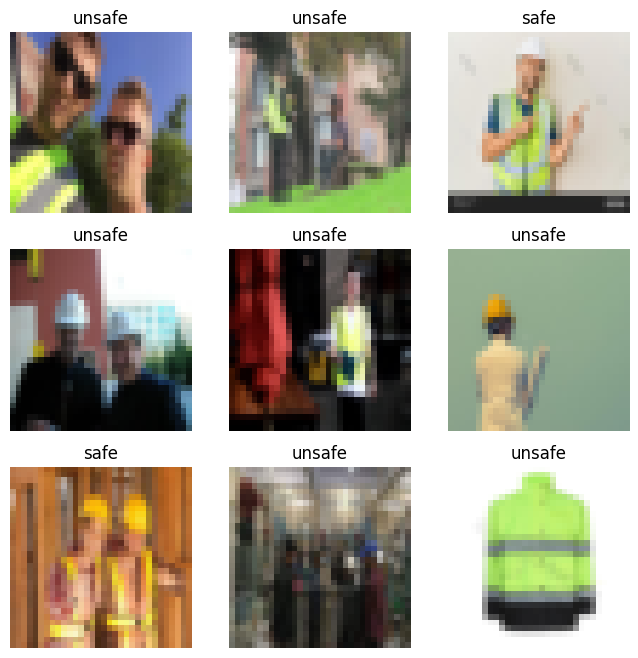

In [ ]:
#sample image
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(lenet_train_dataset), size=(1,)).item()
    img, label = lenet_train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(classes[label])
    plt.axis("off")
    plt.imshow(torch.permute(img, (1,2,0)), )
plt.show()

In [4]:

def train(model, train_loader, epoch):
    model.train()
    total = 0
    correct = 0
    criterion = nn.CrossEntropyLoss()
    for batch_idx, (data, target) in enumerate(train_loader):
        if cuda:
            data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        logits = model(data)
        probas = F.softmax(logits, dim=1)
        loss = criterion(logits, target)
        loss.backward()
        optimizer.step()
        total += target.size(0)
        _, predicted = torch.max(probas, 1)
        correct += (predicted == target).sum()
        if batch_idx % logging_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data )
            )
        n_iter = (epoch - 1) * len(train_loader) + batch_idx + 1
        accuracy = 100 * correct // total

    #1:lenet5 | 2:ResNet18 3:ResNet50 4:ResNet101 | 5:DenseNet121 6:DenseNet161
    model_name = model.name
    if model_name == 'LeNet5':
        train_accuracy[0][epoch-1] = accuracy
    elif model_name == 'ResNet18':
        train_accuracy[1][epoch-1] = accuracy
    elif model_name == 'ResNet50':
        train_accuracy[2][epoch-1] = accuracy
    elif model_name == 'ResNet101':
        train_accuracy[3][epoch-1] = accuracy
    elif model_name == 'DenseNet121':
        train_accuracy[4][epoch-1] = accuracy
    elif model_name == 'DenseNet161':
        train_accuracy[5][epoch-1] = accuracy


    print(f'Train accuracy: {accuracy} %')

def test(model, test_loader, epoch):
    model.eval()
    correct = 0
    total =0
    criterion = nn.CrossEntropyLoss(size_average = False)
    for batch_idx, (data, target) in enumerate(test_loader):
        # [insert-code: move data to GPU]
        if cuda:
            data, target = data.cuda(), target.cuda()


        logits = model(data)
        probas = F.softmax(logits, dim=1)
        # the class with the highest energy is what we choose as prediction
        # print(probas.data.shape)
        _, predicted = torch.max(probas, 1)
        total += target.size(0)
        correct += (predicted == target).sum()
        n_iter = epoch * len(test_loader)
        accuracy = 100 * correct // total
    model_name = model.name
    if model_name == 'LeNet5':
        test_accuracy[0][epoch-1] = accuracy
    elif model_name == 'ResNet18':
        test_accuracy[1][epoch-1] = accuracy
    elif model_name == 'ResNet50':
        test_accuracy[2][epoch-1] = accuracy
    elif model_name == 'ResNet101':
        test_accuracy[3][epoch-1] = accuracy
    elif model_name == 'DenseNet121':
        test_accuracy[4][epoch-1] = accuracy
    elif model_name == 'DenseNet161':
        test_accuracy[5][epoch-1] = accuracy
    print(f'Test Accuracy: {100 * correct // total} %')

def validtest(model, valid_loader, epoch):
    global best_accuracy
    model.eval()
    correct = 0
    total =0
    criterion = nn.CrossEntropyLoss(size_average = False)
    for batch_idx, (data, target) in enumerate(valid_loader):
        # [insert-code: move data to GPU]
        if cuda:
            data, target = data.cuda(), target.cuda()


        logits = model(data)
        probas = F.softmax(logits, dim=1)
        # the class with the highest energy is what we choose as prediction
        # print(probas.data.shape)
        _, predicted = torch.max(probas, 1)
        total += target.size(0)
        correct += (predicted == target).sum()
        n_iter = epoch * len(valid_loader)
        accuracy = 100 * correct // total
    model_name = model.name
    if model_name == 'LeNet5':
        valid_accuracy[0][epoch-1] = accuracy
    elif model_name == 'ResNet18':
        valid_accuracy[1][epoch-1] = accuracy
    elif model_name == 'ResNet50':
        valid_accuracy[2][epoch-1] = accuracy
    elif model_name == 'ResNet101':
        valid_accuracy[3][epoch-1] = accuracy
    elif model_name == 'DenseNet121':
        valid_accuracy[4][epoch-1] = accuracy
    elif model_name == 'DenseNet161':
        valid_accuracy[5][epoch-1] = accuracy
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        if colab:
            torch.save(model.state_dict() ,f'/content/gdrive/MyDrive/models/{model.name}_{datetime_str}_{epoch}.pt')
        else:
          torch.save(model.state_dict() ,f'./models/{model.name}_{datetime_str}_{epoch}.pt')
    print(f'Validation Accuracy: {100 * correct // total} %')


In [ ]:
layer_1_n_filters = 32
layer_2_n_filters = 64
fc_1_n_nodes = 1024
padding="same"
kernel_size = 5
final_length = 8
class LeNet5(nn.Module):
    def __init__(self, num_classes, grayscale = False):
        super(LeNet5,self).__init__()
        self.grayscale = grayscale
        self.num_classes = num_classes
        if self.grayscale:
            in_channels = 1
        else:
            in_channels = 3
        self.features = nn.Sequential(
            nn.Conv2d(in_channels, layer_1_n_filters, kernel_size, padding = padding),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(layer_1_n_filters, layer_2_n_filters, kernel_size, padding = padding),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(final_length*final_length*layer_2_n_filters, fc_1_n_nodes),
            nn.Tanh(),
            nn.Linear(fc_1_n_nodes, num_classes)
        )
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x,1)
        logits = self.classifier(x)
        #probas = F.softmax(logits, dim=1)
        return logits


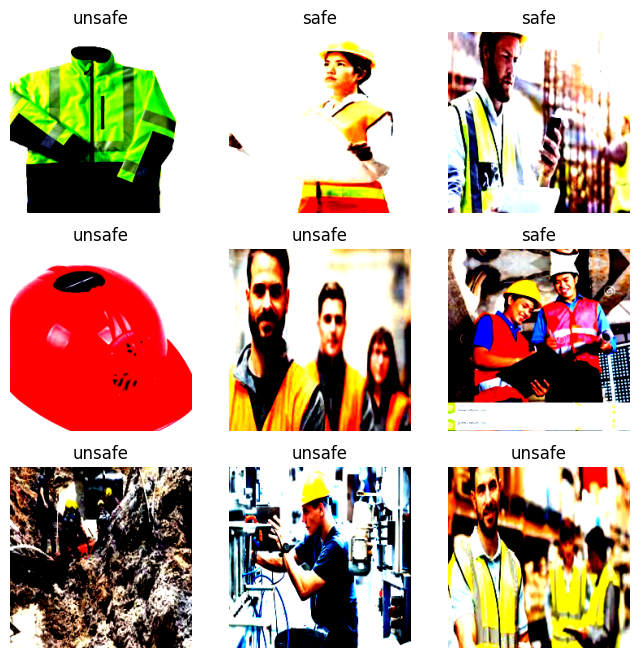

In [ ]:
#res data set resize tp 224x224
res_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4482, 0.4371, 0.4043],
                         std=[0.2686, 0.2613, 0.2761])
])
res_transform2 = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4482, 0.4371, 0.4043],
                         std=[0.2686, 0.2613, 0.2761])
])
res_train_dataset = datasets.ImageFolder(root=train_root, transform=res_transform2)
res_test_dataset = datasets.ImageFolder(root=test_root, transform=res_transform)
res_valid_dataset = datasets.ImageFolder(root=valid_root, transform=res_transform)
res_valid_loader = DataLoader(res_valid_dataset, batch_size = batch_size, shuffle = True, num_workers=2)
res_train_loader = DataLoader(res_train_dataset, batch_size = batch_size, shuffle = True, num_workers=2)
res_test_loader = DataLoader(res_test_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(res_train_dataset), size=(1,)).item()
    img, label = res_train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(classes[label])
    plt.axis("off")
    plt.imshow(torch.permute(img, (1,2,0)), )
plt.show()

In [5]:
#densenet data loading and preporcessing
dense_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4482, 0.4371, 0.4043],
                         std=[0.2686, 0.2613, 0.2761]),

])
dense_transform2 = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4482, 0.4371, 0.4043],
                         std=[0.2686, 0.2613, 0.2761]),

])
dense_train_dataset = datasets.ImageFolder(root=train_root, transform=dense_transform2)
dense_test_dataset = datasets.ImageFolder(root=test_root, transform=dense_transform)
dense_valid_dataset = datasets.ImageFolder(root=valid_root, transform=dense_transform)
dense_valid_loader = DataLoader(dense_valid_dataset, batch_size = batch_size, shuffle = True, num_workers=2)
dense_train_loader = DataLoader(dense_train_dataset, batch_size = batch_size, shuffle = True, num_workers=2)
dense_test_loader = DataLoader(dense_test_dataset, batch_size=batch_size, shuffle=True, num_workers=2)


In [ ]:
#lenet 5 train
LenetModel = LeNet5(num_classes, False)
LenetModel.name = 'LeNet5'
if cuda:
    LenetModel.cuda()

optimizer = optim.Adam(LenetModel.parameters(), lr=lr, weight_decay=0.004)
best_accuracy  = 0
for epoch in range(1, epochs + 1):
    train(LenetModel, lenet_train_loader, epoch)
    test(LenetModel, lenet_test_loader, epoch)
    validtest(LenetModel, lenet_valid_loader , epoch)


Train Epoch: 1 [0/1620 (0%)]	Loss: 0.694308
Train Epoch: 1 [320/1620 (20%)]	Loss: 0.692649
Train Epoch: 1 [640/1620 (39%)]	Loss: 0.677650
Train Epoch: 1 [960/1620 (59%)]	Loss: 0.688719
Train Epoch: 1 [1280/1620 (78%)]	Loss: 0.688240
Train Epoch: 1 [1000/1620 (98%)]	Loss: 0.665656
Train accuracy: 53 %


/opt/anaconda3/lib/python3.11/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Test Accuracy: 59 %
Validation Accuracy: 57 %
Train Epoch: 2 [0/1620 (0%)]	Loss: 0.653306
Train Epoch: 2 [320/1620 (20%)]	Loss: 0.639313
Train Epoch: 2 [640/1620 (39%)]	Loss: 0.664762
Train Epoch: 2 [960/1620 (59%)]	Loss: 0.621309
Train Epoch: 2 [1280/1620 (78%)]	Loss: 0.658347
Train Epoch: 2 [1000/1620 (98%)]	Loss: 0.551255
Train accuracy: 58 %
Test Accuracy: 54 %
Validation Accuracy: 50 %
Train Epoch: 3 [0/1620 (0%)]	Loss: 0.631780
Train Epoch: 3 [320/1620 (20%)]	Loss: 0.577010
Train Epoch: 3 [640/1620 (39%)]	Loss: 0.613882
Train Epoch: 3 [960/1620 (59%)]	Loss: 0.652627
Train Epoch: 3 [1280/1620 (78%)]	Loss: 0.630274
Train Epoch: 3 [1000/1620 (98%)]	Loss: 0.595463
Train accuracy: 59 %
Test Accuracy: 58 %
Validation Accuracy: 52 %
Train Epoch: 4 [0/1620 (0%)]	Loss: 0.612590
Train Epoch: 4 [320/1620 (20%)]	Loss: 0.557732
Train Epoch: 4 [640/1620 (39%)]	Loss: 0.629797
Train Epoch: 4 [960/1620 (59%)]	Loss: 0.555611
Train Epoch: 4 [1280/1620 (78%)]	Loss: 0.584068
Train Epoch: 4 [1000/1620

In [ ]:
#train resnet18

ResModel18 = models.resnet18(pretrained=True)
ResModel18.name = 'ResNet18'
if cuda:
    ResModel18.cuda()
num_ftrs = ResModel18.fc.in_features
ResModel18.fc = nn.Linear(num_ftrs, 2)
if cuda:
    ResModel18.cuda()

optimizer = optim.Adam(ResModel18.parameters(), lr=lr, weight_decay=0.004)

best_accuracy  = 0
for epoch in range(1, epochs + 1):
    train(ResModel18, res_train_loader, epoch)
    test(ResModel18,res_test_loader, epoch)
    validtest(ResModel18,res_valid_loader,  epoch)

/opt/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Train Epoch: 1 [0/1620 (0%)]	Loss: 0.939626
Train Epoch: 1 [320/1620 (20%)]	Loss: 0.680053
Train Epoch: 1 [640/1620 (39%)]	Loss: 0.594038
Train Epoch: 1 [960/1620 (59%)]	Loss: 0.636111
Train Epoch: 1 [1280/1620 (78%)]	Loss: 0.573620
Train Epoch: 1 [1000/1620 (98%)]	Loss: 0.389835
Train accuracy: 67 %
Test Accuracy: 65 %
Validation Accuracy: 70 %
Train Epoch: 2 [0/1620 (0%)]	Loss: 0.396683
Train Epoch: 2 [320/1620 (20%)]	Loss: 0.578079
Train Epoch: 2 [640/1620 (39%)]	Loss: 0.523784
Train Epoch: 2 [960/1620 (59%)]	Loss: 0.371583
Train Epoch: 2 [1280/1620 (78%)]	Loss: 0.396611
Train Epoch: 2 [1000/1620 (98%)]	Loss: 0.552703
Train accuracy: 75 %
Test Accuracy: 76 %
Validation Accuracy: 76 %
Train Epoch: 3 [0/1620 (0%)]	Loss: 0.358843
Train Epoch: 3 [320/1620 (20%)]	Loss: 0.376392
Train Epoch: 3 [640/1620 (39%)]	Loss: 0.585239
Train Epoch: 3 [960/1620 (59%)]	Loss: 0.443708
Train Epoch: 3 [1280/1620 (78%)]	Loss: 0.451599
Train Epoch: 3 [1000/1620 (98%)]	Loss: 0.393296
Train accuracy: 78 %
Te

In [ ]:
#train resnet50
ResModel50 = models.resnet50(pretrained=True)
ResModel50.name = 'ResNet50'
if cuda:
    ResModel50.cuda()
num_ftrs = ResModel50.fc.in_features
ResModel50.fc = nn.Linear(num_ftrs, 2)
if cuda:
    ResModel50.cuda()
optimizer = optim.Adam(ResModel50.parameters(), lr=lr, weight_decay=0.004)

best_accuracy  = 0
for epoch in range(1, epochs + 1):
    train(ResModel50, res_train_loader, epoch)
    test(ResModel50,res_test_loader, epoch)
    validtest(ResModel50,res_valid_loader,  epoch)


/opt/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /Users/yangchunfu/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████████████████████████████████| 97.8M/97.8M [00:03<00:00, 30.7MB/s]


Train Epoch: 1 [0/1620 (0%)]	Loss: 0.696213
Train Epoch: 1 [320/1620 (20%)]	Loss: 0.548200
Train Epoch: 1 [640/1620 (39%)]	Loss: 0.760233
Train Epoch: 1 [960/1620 (59%)]	Loss: 0.649305
Train Epoch: 1 [1280/1620 (78%)]	Loss: 0.569063
Train Epoch: 1 [1000/1620 (98%)]	Loss: 0.561407
Train accuracy: 58 %
Test Accuracy: 59 %
Validation Accuracy: 59 %
Train Epoch: 2 [0/1620 (0%)]	Loss: 0.601021
Train Epoch: 2 [320/1620 (20%)]	Loss: 0.559907
Train Epoch: 2 [640/1620 (39%)]	Loss: 0.735323
Train Epoch: 2 [960/1620 (59%)]	Loss: 0.640112
Train Epoch: 2 [1280/1620 (78%)]	Loss: 0.625662
Train Epoch: 2 [1000/1620 (98%)]	Loss: 0.548691
Train accuracy: 67 %
Test Accuracy: 52 %
Validation Accuracy: 51 %
Train Epoch: 3 [0/1620 (0%)]	Loss: 0.580328
Train Epoch: 3 [320/1620 (20%)]	Loss: 0.594387
Train Epoch: 3 [640/1620 (39%)]	Loss: 0.645559
Train Epoch: 3 [960/1620 (59%)]	Loss: 0.573892
Train Epoch: 3 [1280/1620 (78%)]	Loss: 0.841369
Train Epoch: 3 [1000/1620 (98%)]	Loss: 0.608432
Train accuracy: 65 %
Te

In [ ]:
#train resnet101
ResModel101 = models.resnet101(pretrained=True)
ResModel101.name = 'ResNet101'
if cuda:
    ResModel101.cuda()
num_ftrs = ResModel101.fc.in_features
ResModel101.fc = nn.Linear(num_ftrs, 2)
if cuda:
    ResModel101.cuda()
optimizer = optim.Adam(ResModel101.parameters(), lr=lr, weight_decay=0.004)

best_accuracy  = 0
for epoch in range(1, epochs + 1):
    train(ResModel101, res_train_loader, epoch)
    test(ResModel101,res_test_loader, epoch)
    validtest(ResModel101,res_valid_loader,  epoch)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Train Epoch: 1 [0/1620 (0%)]	Loss: 0.733691
Train Epoch: 1 [320/1620 (20%)]	Loss: 0.797673
Train Epoch: 1 [640/1620 (39%)]	Loss: 0.694429
Train Epoch: 1 [960/1620 (59%)]	Loss: 0.676278
Train Epoch: 1 [1280/1620 (78%)]	Loss: 0.636356
Train Epoch: 1 [1000/1620 (98%)]	Loss: 0.738623
Train accuracy: 55 %


/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Test Accuracy: 57 %
Validation Accuracy: 56 %
Train Epoch: 2 [0/1620 (0%)]	Loss: 0.681042
Train Epoch: 2 [320/1620 (20%)]	Loss: 0.693995
Train Epoch: 2 [640/1620 (39%)]	Loss: 0.683035
Train Epoch: 2 [960/1620 (59%)]	Loss: 0.723893
Train Epoch: 2 [1280/1620 (78%)]	Loss: 0.682897
Train Epoch: 2 [1000/1620 (98%)]	Loss: 0.597825
Train accuracy: 54 %
Test Accuracy: 62 %
Validation Accuracy: 54 %
Train Epoch: 3 [0/1620 (0%)]	Loss: 0.633823
Train Epoch: 3 [320/1620 (20%)]	Loss: 0.670346
Train Epoch: 3 [640/1620 (39%)]	Loss: 0.731644
Train Epoch: 3 [960/1620 (59%)]	Loss: 0.633249
Train Epoch: 3 [1280/1620 (78%)]	Loss: 0.693267
Train Epoch: 3 [1000/1620 (98%)]	Loss: 0.671838
Train accuracy: 59 %
Test Accuracy: 60 %
Validation Accuracy: 55 %
Train Epoch: 4 [0/1620 (0%)]	Loss: 0.596146
Train Epoch: 4 [320/1620 (20%)]	Loss: 0.688542
Train Epoch: 4 [640/1620 (39%)]	Loss: 0.655806
Train Epoch: 4 [960/1620 (59%)]	Loss: 0.680057
Train Epoch: 4 [1280/1620 (78%)]	Loss: 0.649998
Train Epoch: 4 [1000/1620

In [ ]:
#denseNet 121
DenseModel121 = models.densenet121(pretrained=True)
DenseModel121.name = 'DenseNet121'
if cuda:
    DenseModel121.cuda()
num_ftrs = DenseModel121.classifier.in_features
DenseModel121.fc = nn.Linear(num_ftrs, 2)

optimizer = optim.Adam(DenseModel121.parameters(), lr=lr, weight_decay=0.004)

best_accuracy  = 0
for epoch in range(1, epochs + 1):
    train(DenseModel121, dense_train_loader, epoch)
    test(DenseModel121,dense_test_loader, epoch)
    validtest(DenseModel121,dense_valid_loader,  epoch)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Train Epoch: 1 [0/1620 (0%)]	Loss: 9.103476
Train Epoch: 1 [320/1620 (20%)]	Loss: 1.113733
Train Epoch: 1 [640/1620 (39%)]	Loss: 0.757740
Train Epoch: 1 [960/1620 (59%)]	Loss: 0.639859
Train Epoch: 1 [1280/1620 (78%)]	Loss: 0.520910
Train Epoch: 1 [1000/1620 (98%)]	Loss: 0.460567
Train accuracy: 66 %
Test Accuracy: 76 %
Validation Accuracy: 73 %
Train Epoch: 2 [0/1620 (0%)]	Loss: 0.685915
Train Epoch: 2 [320/1620 (20%)]	Loss: 0.386247
Train Epoch: 2 [640/1620 (39%)]	Loss: 0.223075
Train Epoch: 2 [960/1620 (59%)]	Loss: 0.239003
Train Epoch: 2 [1280/1620 (78%)]	Loss: 0.318223
Train Epoch: 2 [1000/1620 (98%)]	Loss: 0.278310
Train accuracy: 80 %
Test Accuracy: 83 %
Validation Accuracy: 83 %
Train Epoch: 3 [0/1620 (0%)]	Loss: 0.552198
Train Epoch: 3 [320/1620 (20%)]	Loss: 0.279212
Train Epoch: 3 [640/1620 (39%)]	Loss: 0.530414
Train Epoch: 3 [960/1620 (59%)]	Loss: 0.418024
Train Epoch: 3 [1280/1620 (78%)]	Loss: 0.882394
Train Epoch: 3 [1000/1620 (98%)]	Loss: 0.356906
Train accuracy: 83 %
Te

In [8]:
#densenet 161
DenseModel169 = models.densenet169(pretrained=True)
DenseModel169.name = 'DenseNet161'
if cuda:
    DenseModel169.cuda()
num_ftrs = DenseModel169.classifier.in_features
DenseModel169.fc = nn.Linear(num_ftrs, 2)
optimizer = optim.Adam(DenseModel169.parameters(), lr=lr, weight_decay=0.004)
best_accuracy  = 0

for epoch in range(1, epochs + 1):
    train(DenseModel169, dense_train_loader, epoch)
    test(DenseModel169,dense_test_loader, epoch)
    validtest(DenseModel169,dense_valid_loader,  epoch)

Train Epoch: 1 [0/1620 (0%)]	Loss: 9.642870
Train Epoch: 1 [320/1620 (20%)]	Loss: 0.567884
Train Epoch: 1 [640/1620 (39%)]	Loss: 0.626047
Train Epoch: 1 [960/1620 (59%)]	Loss: 0.560567
Train Epoch: 1 [1280/1620 (78%)]	Loss: 0.526674
Train Epoch: 1 [1000/1620 (98%)]	Loss: 0.614836
Train accuracy: 66 %
Test Accuracy: 66 %
Validation Accuracy: 72 %
Train Epoch: 2 [0/1620 (0%)]	Loss: 0.446607
Train Epoch: 2 [320/1620 (20%)]	Loss: 0.445691
Train Epoch: 2 [640/1620 (39%)]	Loss: 0.525784
Train Epoch: 2 [960/1620 (59%)]	Loss: 0.411004
Train Epoch: 2 [1280/1620 (78%)]	Loss: 0.468810
Train Epoch: 2 [1000/1620 (98%)]	Loss: 0.424763
Train accuracy: 78 %
Test Accuracy: 70 %
Validation Accuracy: 72 %
Train Epoch: 3 [0/1620 (0%)]	Loss: 0.580177
Train Epoch: 3 [320/1620 (20%)]	Loss: 0.912218
Train Epoch: 3 [640/1620 (39%)]	Loss: 0.492386
Train Epoch: 3 [960/1620 (59%)]	Loss: 0.389231
Train Epoch: 3 [1280/1620 (78%)]	Loss: 0.415454
Train Epoch: 3 [1000/1620 (98%)]	Loss: 0.434418
Train accuracy: 80 %
Te

In [20]:
print(train_accuracy)
print(test_accuracy)
print(valid_accuracy)

[[53. 58. 59. 62. 62. 64. 63. 63. 65. 66. 65. 68. 69. 70. 69. 71. 70. 72.
  73. 71. 72. 72. 74. 75. 75. 76. 76. 76. 76. 77. 78. 78. 79. 80. 80. 80.
  81. 78. 82. 83.]
 [67. 75. 78. 79. 78. 80. 78. 77. 81. 78. 78. 81. 79. 78. 78. 79. 79. 79.
  78. 81. 80. 80. 81. 81. 81. 80. 81. 81. 83. 80. 81. 80. 84. 83. 83. 82.
  84. 83. 85. 83.]
 [58. 67. 65. 64. 64. 65. 66. 69. 67. 66. 67. 68. 69. 69. 68. 70. 72. 71.
  68. 69. 69. 72. 71. 73. 71. 71. 72. 71. 73. 71. 74. 73. 74. 75. 74. 74.
  74. 75. 74. 75.]
 [55. 54. 59. 61. 65. 62. 64. 66. 67. 64. 64. 68. 67. 66. 67. 69. 68. 69.
  70. 71. 71. 70. 72. 73. 71. 72. 73. 73. 74. 73. 74. 75. 75. 74. 76. 75.
  75. 75. 76. 74.]
 [67. 75. 78. 79. 78. 80. 78. 77. 81. 78. 78. 81. 79. 78. 78. 79. 79. 79.
  78. 81. 80. 80. 81. 81. 81. 80. 81. 81. 83. 80. 81. 80. 84. 83. 83. 82.
  84. 83. 85. 83.]
 [66. 78. 80. 81. 80. 81. 81. 79. 80. 78. 81. 78. 81. 82. 82. 82. 80. 82.
  82. 82. 82. 83. 83. 83. 83. 83. 84. 85. 84. 84. 85. 85. 85. 85. 86. 86.
  87. 88. 88. 87.

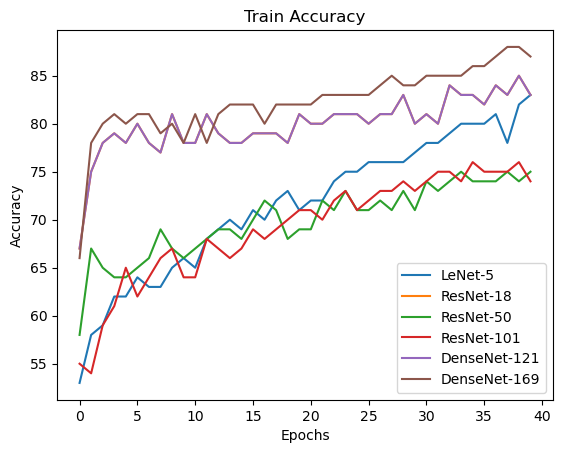

In [36]:
model_name = ['LeNet-5', 'ResNet-18', 'ResNet-50', 'ResNet-101', 'DenseNet-121', 'DenseNet-169']
fig, ax = plt.subplots()

for i in range(train_accuracy.shape[0]):
    ax.plot(train_accuracy[i, :], label=model_name[i])

ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.set_title('Train Accuracy')
ax.legend()

# Show the plot
plt.show()

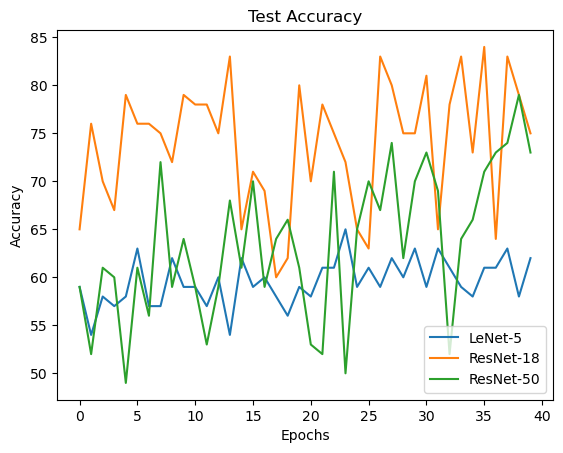

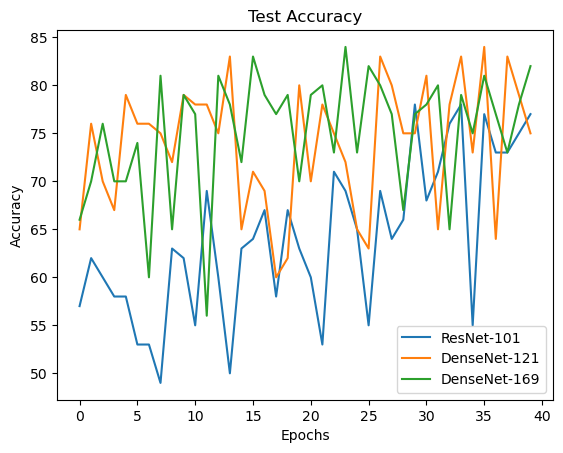

In [46]:
fig, ax = plt.subplots()

# Plot each row as a separate line
for i in range(3):
    ax.plot(test_accuracy[i, :], label=model_name[i])

ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.set_title('Test Accuracy')
ax.legend()

plt.show()

fig, ax = plt.subplots()

# Plot each row as a separate line
for i in range(3,6):
    ax.plot(test_accuracy[i, :], label=model_name[i])

ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.set_title('Test Accuracy')
ax.legend()

plt.show()

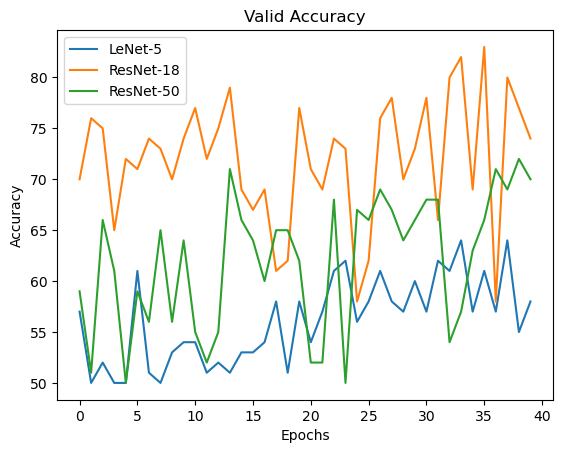

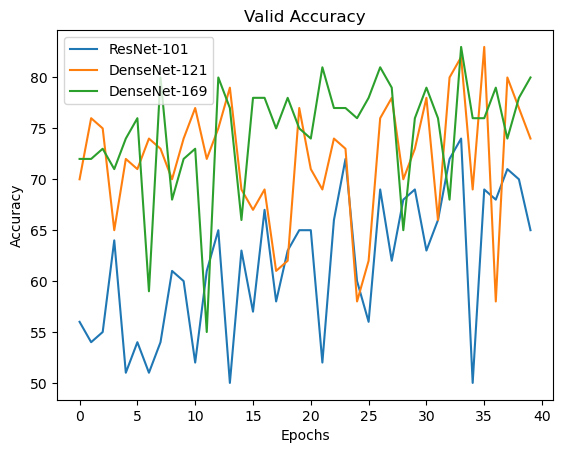

In [48]:
fig, ax = plt.subplots()

for i in range(3):
    ax.plot(valid_accuracy[i, :], label=model_name[i])

ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.set_title('Valid Accuracy')
ax.legend()

# Show the plot
plt.show()

fig, ax = plt.subplots()

# Plot each row as a separate line
for i in range(3,6):
    ax.plot(valid_accuracy[i, :], label=model_name[i])

ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.set_title('Valid Accuracy')
ax.legend()

plt.show()

In [66]:
max_valid = np.max(valid_accuracy, 1)
for i in range(len(max_valid)):
    print(f'Max validation accuracy of {model_name[i]} : {max_valid[i]}')

Max validation accuracy of LeNet-5 : 64.0
Max validation accuracy of ResNet-18 : 83.0
Max validation accuracy of ResNet-50 : 72.0
Max validation accuracy of ResNet-101 : 74.0
Max validation accuracy of DenseNet-121 : 83.0
Max validation accuracy of DenseNet-169 : 83.0
